In [1]:
import agents_env
from agents_env.agent_mimic_eval import HumanoidEnvTrainEval
from agents_env.agent_mimic_train import HumanoidEnvTrain
from utils.SimpleConverter import SimpleConverter
from utils.util_data import *
from copy import deepcopy

In [2]:
from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.apg import train as apg
from brax.training.agents.apg import networks as apg_networks
from brax.io import html, mjcf, model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
from jax import vmap
import jax.random
from jax import lax

In [3]:

import distutils.util
import os
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
#this is just dummy data to initialize the agent
trajectory = SimpleConverter('motions/humanoid3d_punch.txt')
trajectory.load_mocap()
model_path = 'models/final_humanoid.xml'

data_mocap_matrix = jp.asarray(trajectory.data)
data_pos_mocap = jp.asarray(trajectory.data_pos)
data_vel_mocap = jp.asarray(trajectory.data_vel)

data_dict_mocap = trajectory.duration_dict

data_xpos_mocap=jp.asarray(trajectory.data_xpos)
data_xrot_mocap=jp.asarray(trajectory.data_xrot)

In [6]:
#get th kp and kd for the agent
kp,kd = generate_kp_kd_gains()
print(kp)
print(kd)

[1000 1000 1000  100  100  100  400  400  400  300  400  400  400  300
  500  500  500  500  400  400  400  500  500  500  500  400  400  400]
[100 100 100  10  10  10  40  40  40  30  40  40  40  30  50  50  50  50
  40  40  40  50  50  50  50  40  40  40]


In [7]:
import yaml
from box import Box
# Path to your YAML file
yaml_file_path = 'config_params/punch.yaml'
# Load the YAML file
with open(yaml_file_path, 'r') as file:
    args = Box(yaml.safe_load(file))

In [8]:
envs.register_environment('humanoidEnvMimicEval',HumanoidEnvTrainEval )
env_name_eval = 'humanoidEnvMimicEval'
env_eval = envs.get_environment(env_name=env_name_eval,
                           reference_trajectory_qpos=data_pos_mocap,
                           reference_trajectory_qvel = data_vel_mocap,
                            duration_trajectory=trajectory.total_time,
                            dict_duration= data_dict_mocap,
                           model_path=model_path,
                           kp_gains = kp,
                           kd_gains = kd,
                           reference_x_pos=data_xpos_mocap,
                           reference_x_rot=data_xrot_mocap,
                           args=args)
jit_reset = jax.jit(env_eval.reset)
jit_step = jax.jit(env_eval.step)


#select the pd_control
from agents_env.pds_controllers_agents import feedback_pd_controller, stable_pd_controller_action
#env.set_pd_callback(stable_pd_controller_custom_trajectory)
env_eval.set_pd_callback(feedback_pd_controller)

In [9]:
envs.register_environment('humanoidEnvMimic',HumanoidEnvTrain)
env_name = 'humanoidEnvMimic'
env = envs.get_environment(env_name=env_name,
                           reference_trajectory_qpos=data_pos_mocap,
                           reference_trajectory_qvel = data_vel_mocap,
                            duration_trajectory=trajectory.total_time,
                            dict_duration= data_dict_mocap,
                           model_path=model_path,
                           kp_gains = kp,
                           kd_gains = kd,
                           reference_x_pos=data_xpos_mocap,
                           reference_x_rot=data_xrot_mocap,
                           args=args)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


#select the pd_control
from agents_env.pds_controllers_agents import stable_pd_controller_custom_trajectory, stable_pd_controller_trajectory,stable_pd_controller_action,feedback_pd_controller
#env.set_pd_callback(stable_pd_controller_custom_trajectory)
env.set_pd_callback(feedback_pd_controller)

In [10]:
episode_len = env_eval.rollout_lenght
print(episode_len)

65


In [11]:
from RLALG import agent_diffmimic as diff
from RLALG import agent_ppo as ppo
from RLALG import ppo_angent_networks as ppo_networks


In [12]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(512,256),
        value_hidden_layer_sizes=(512,256))
make_networks_factory

functools.partial(<function make_ppo_networks at 0x7f020c18b920>, policy_hidden_layer_sizes=(512, 256), value_hidden_layer_sizes=(512, 256))

num of eval after init 39
env step per traning step 122880
training steps per epoch 3
Episode lenght 64


/tmp/ipykernel_27302/1026906798.py:59: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps* 1.25])
/tmp/ipykernel_27302/1026906798.py:68: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps* 1.25])


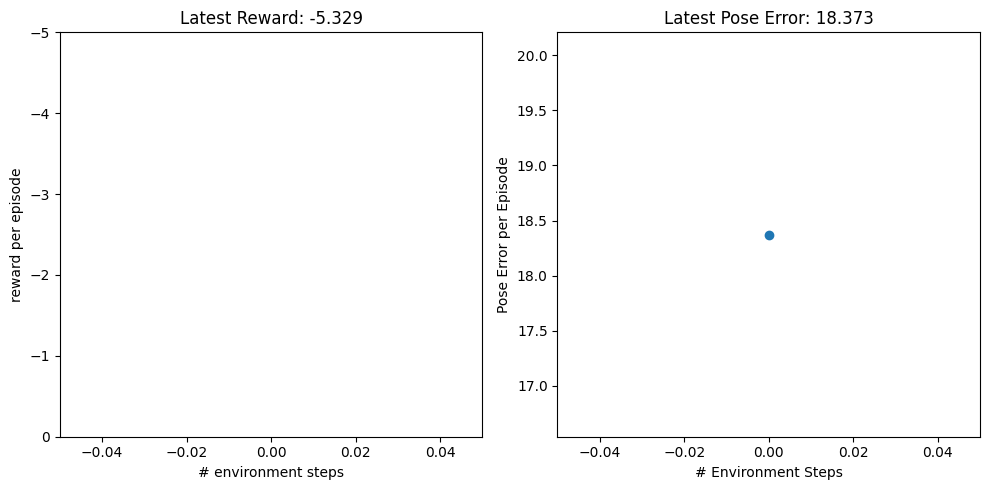

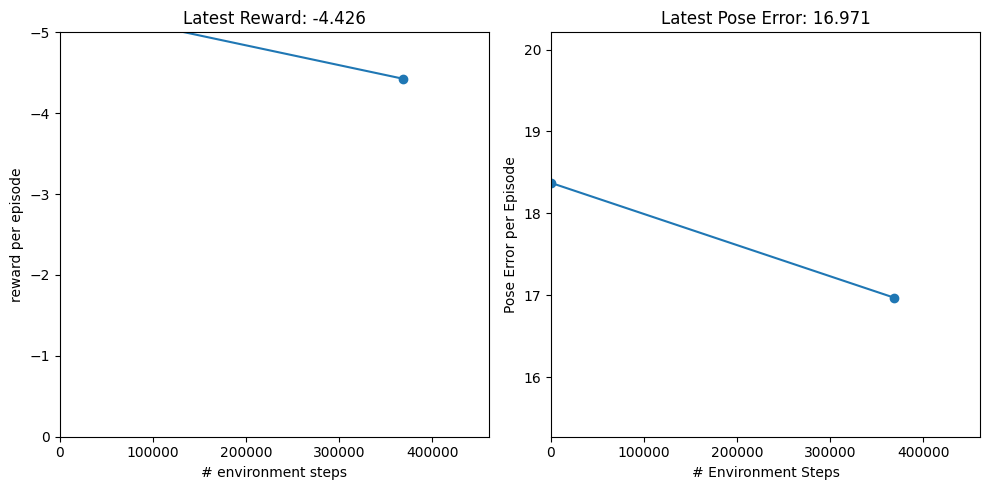

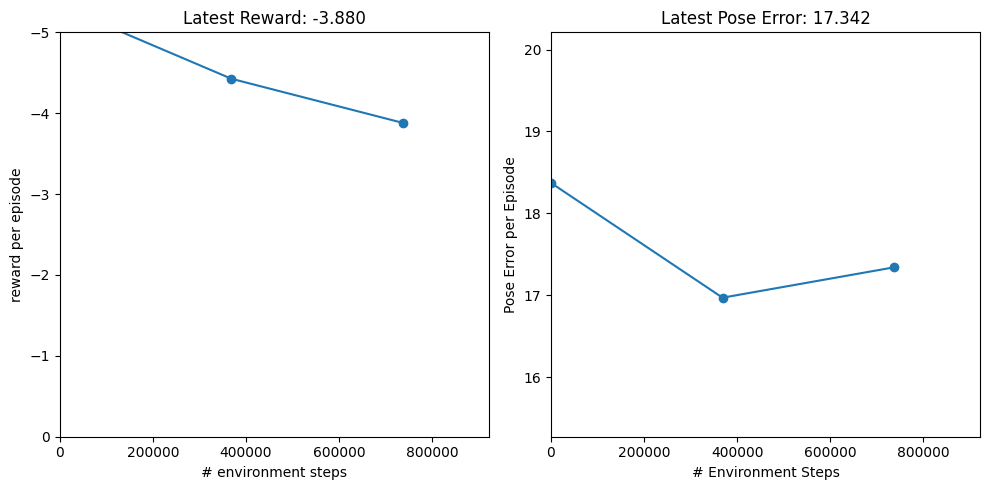

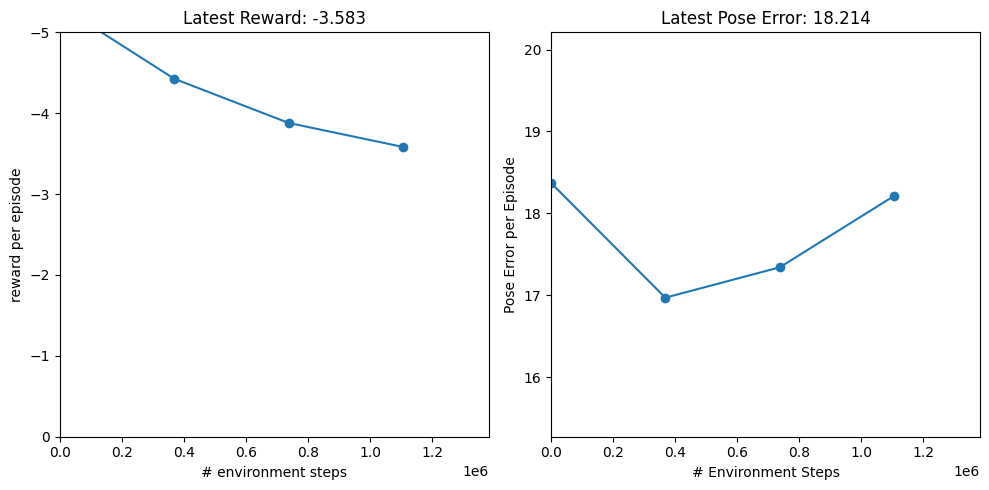

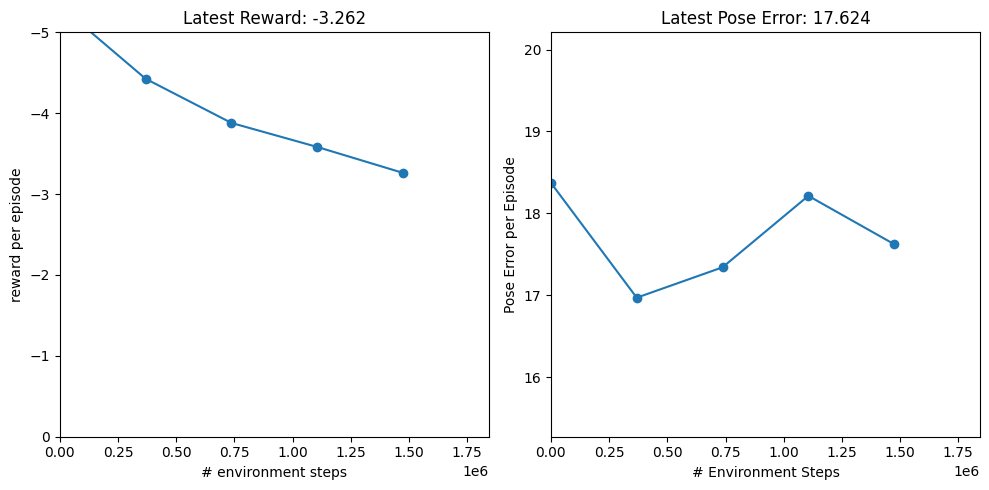

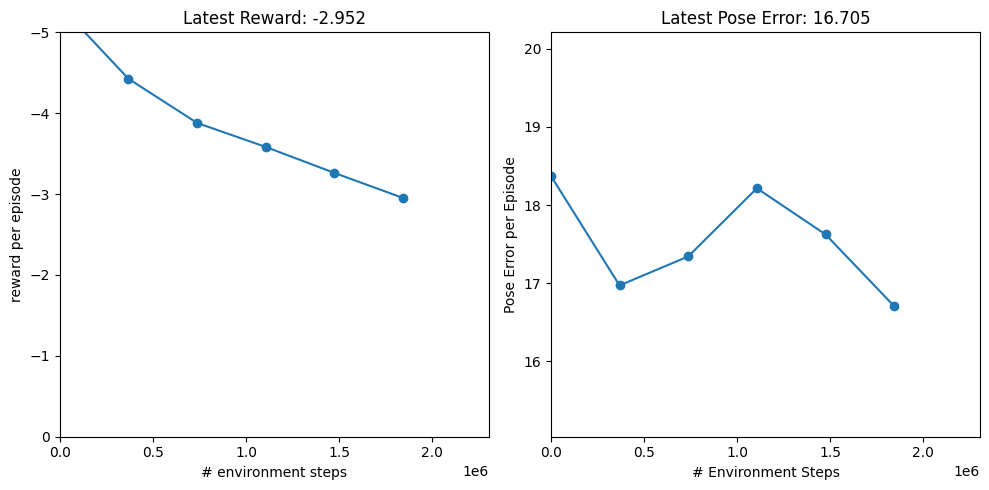

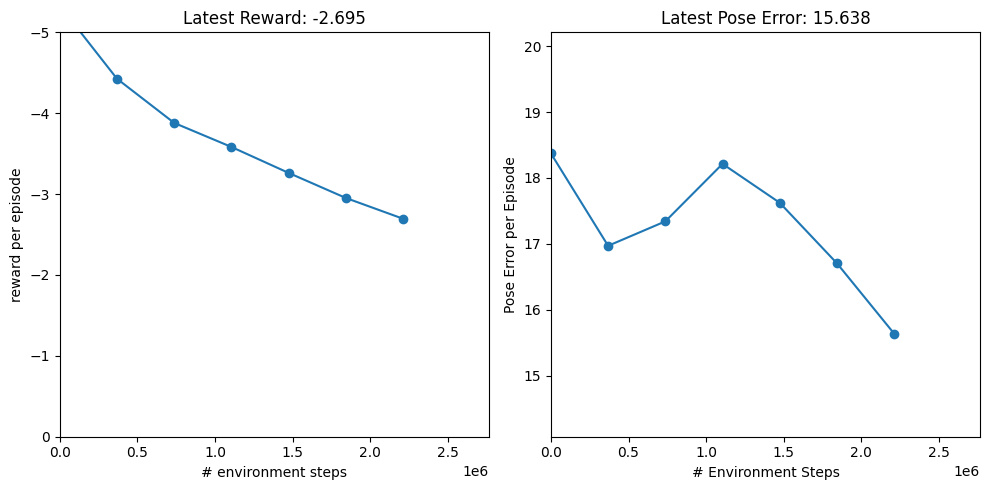

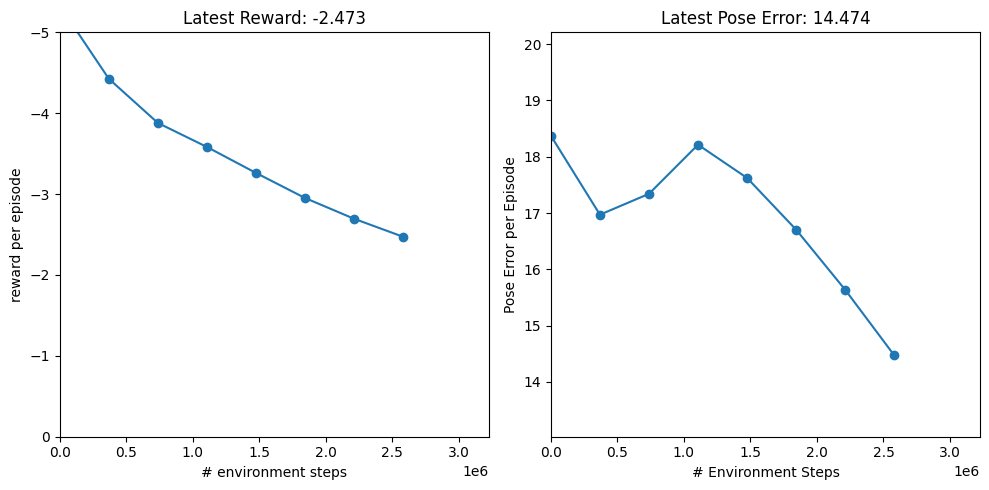

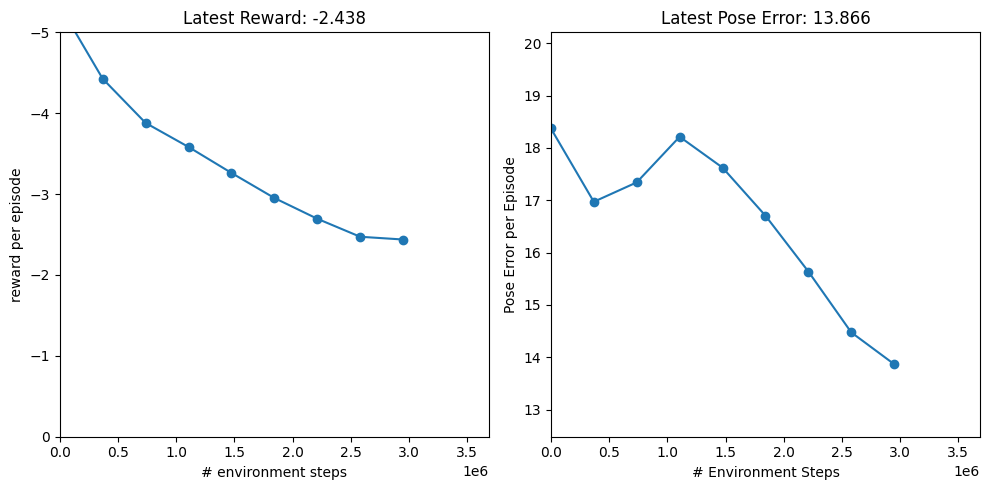

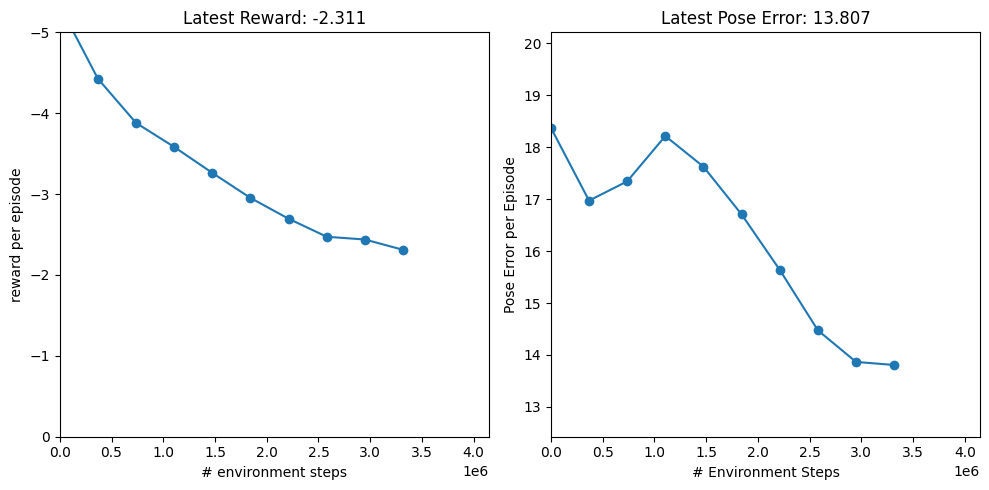

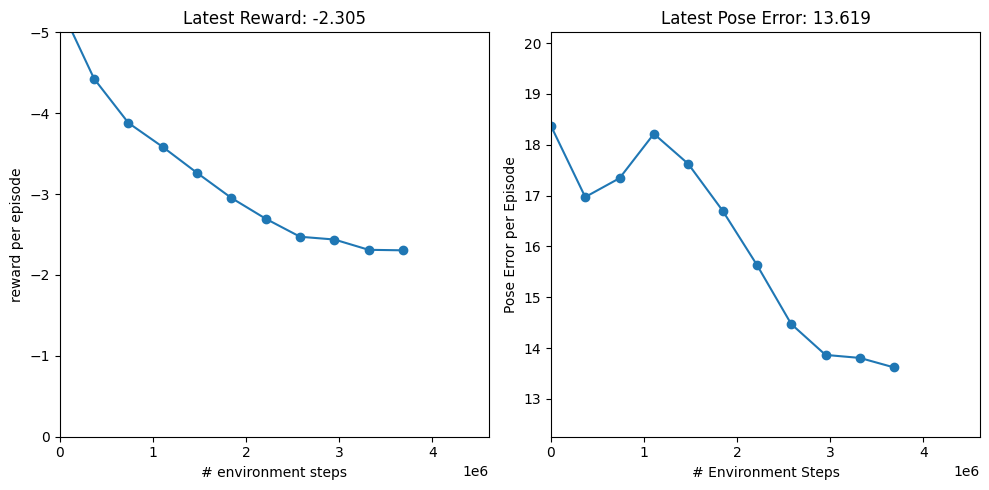

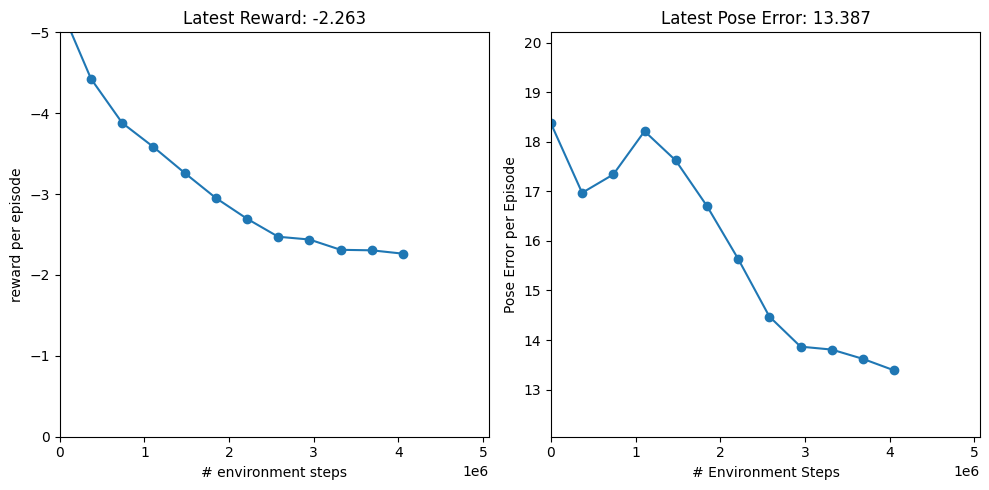

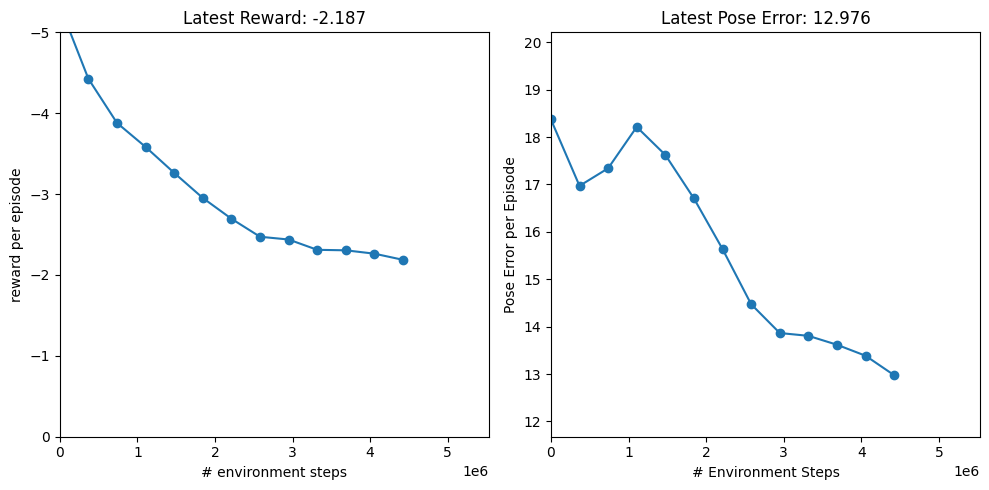

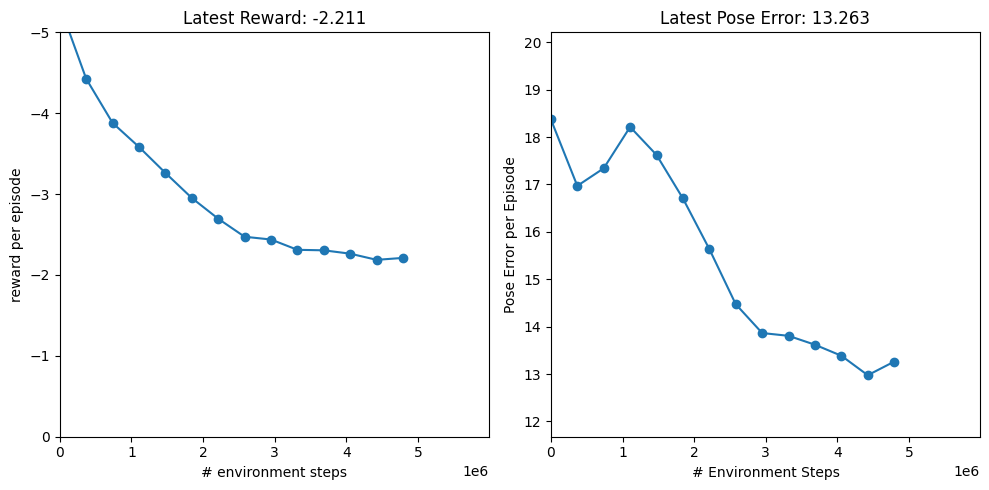

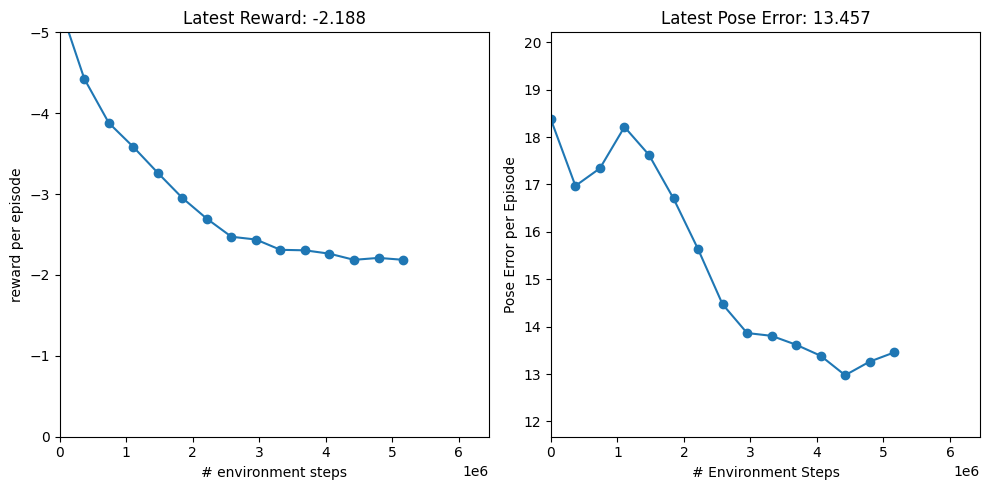

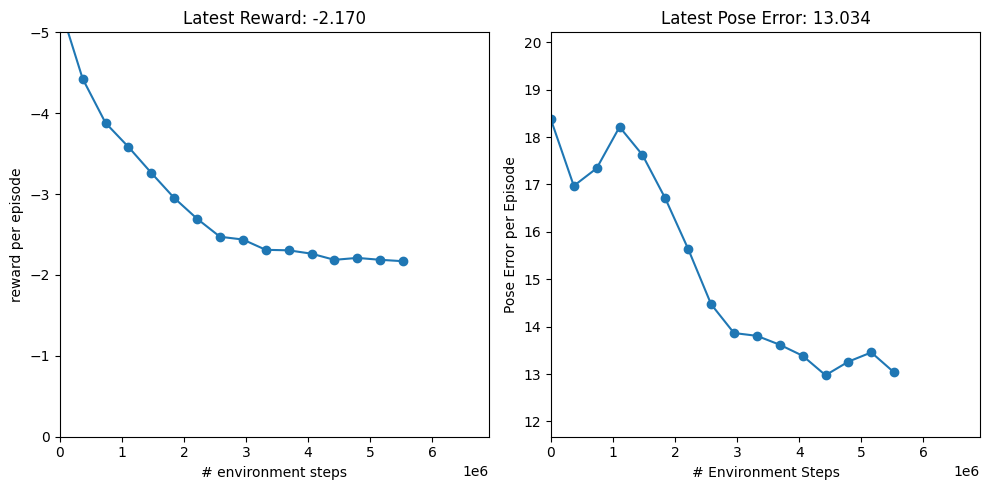

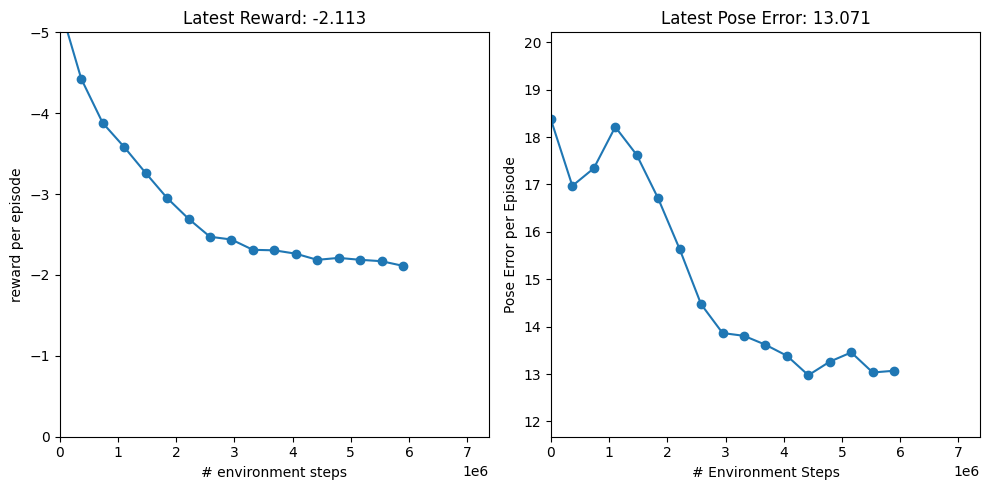

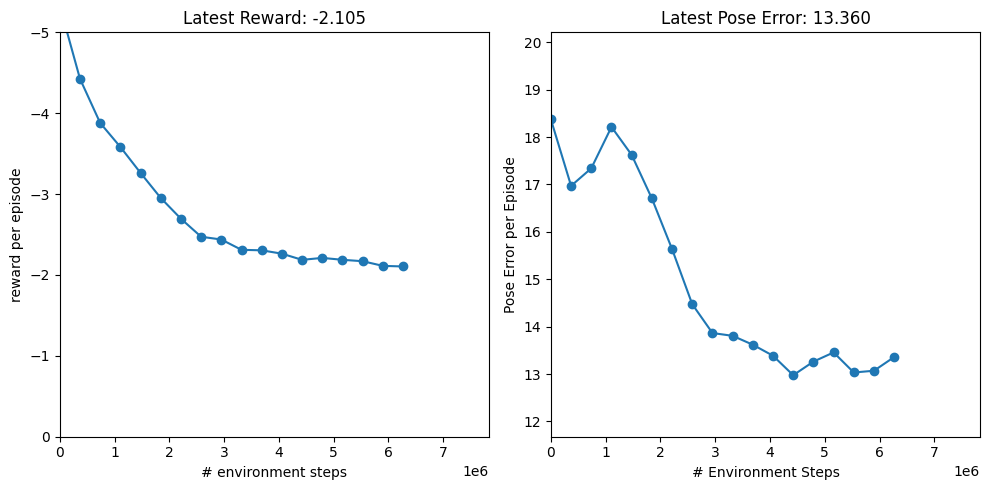

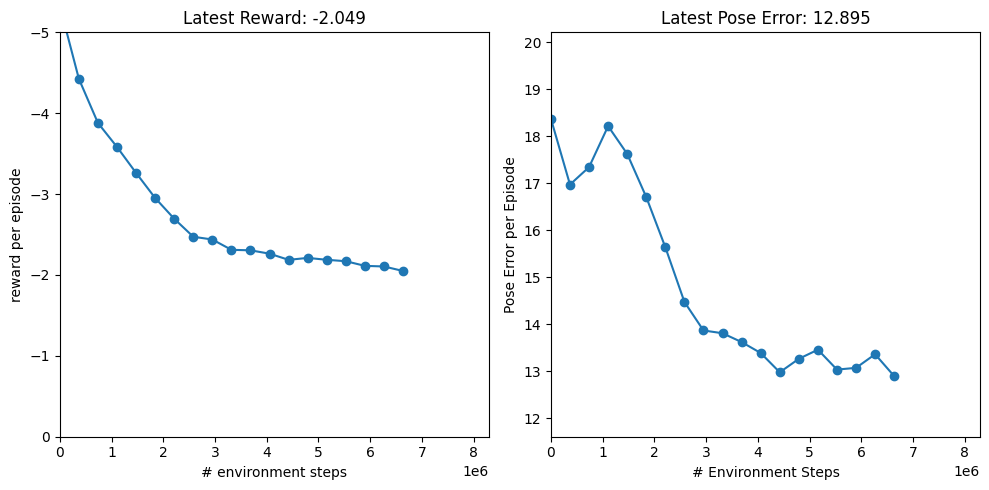

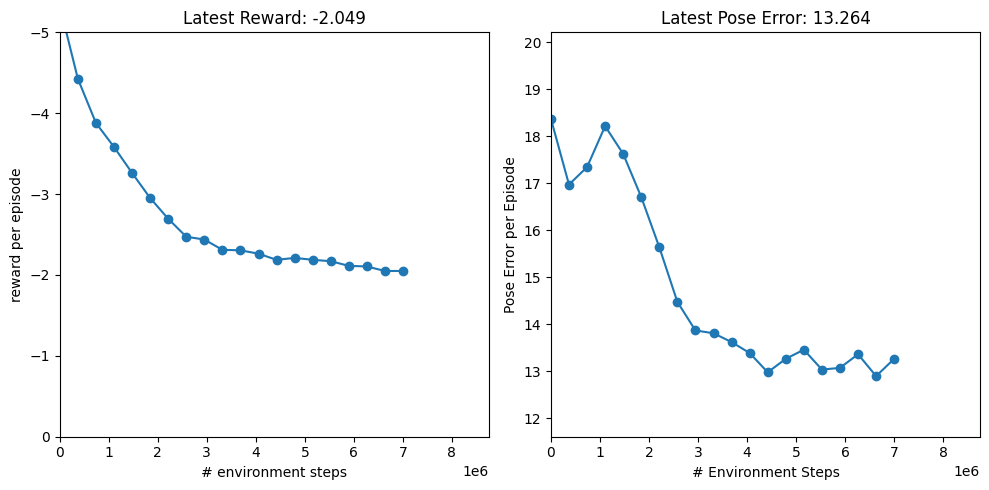

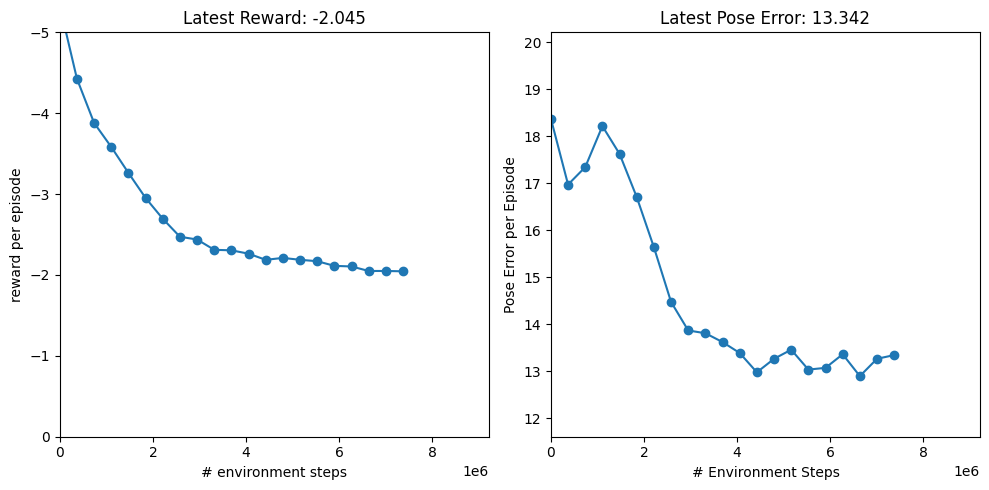

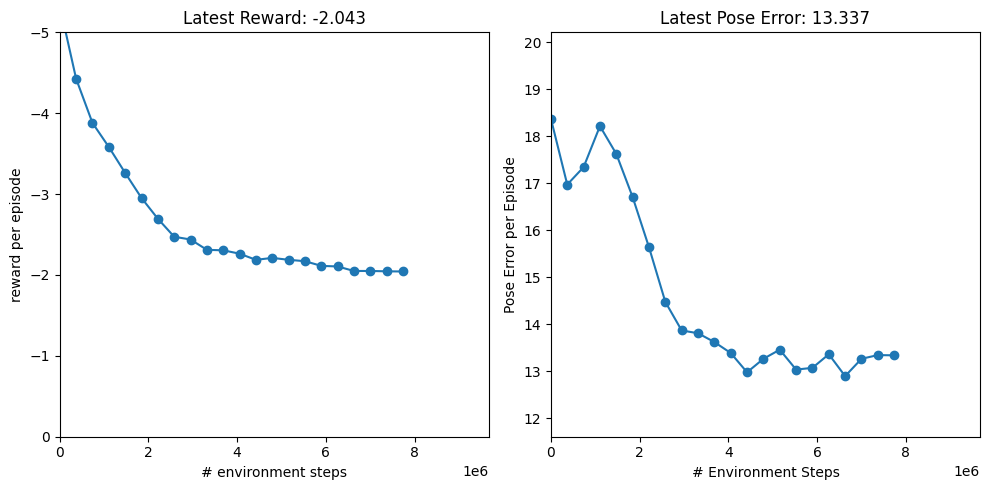

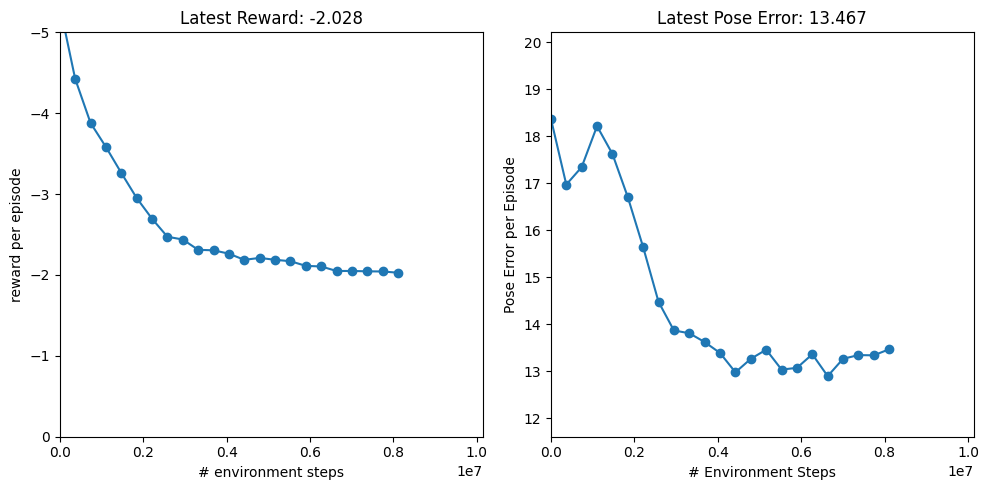

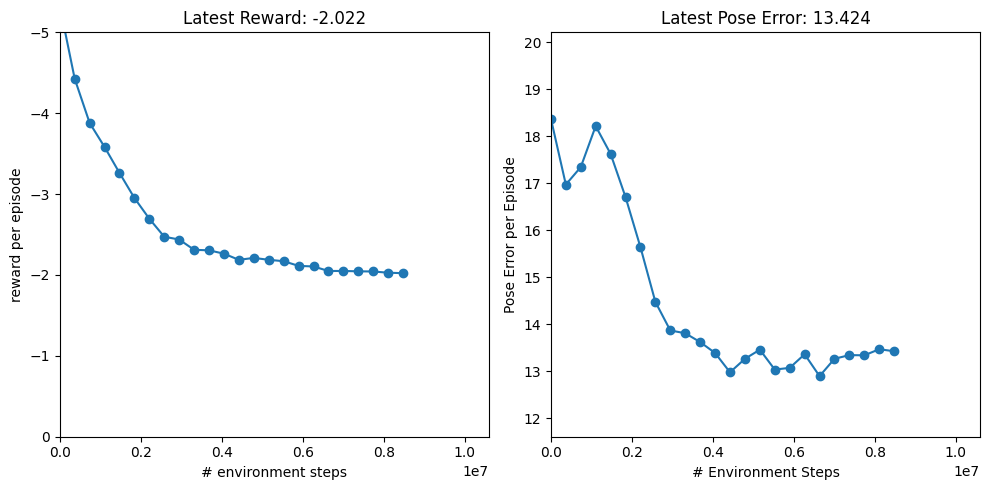

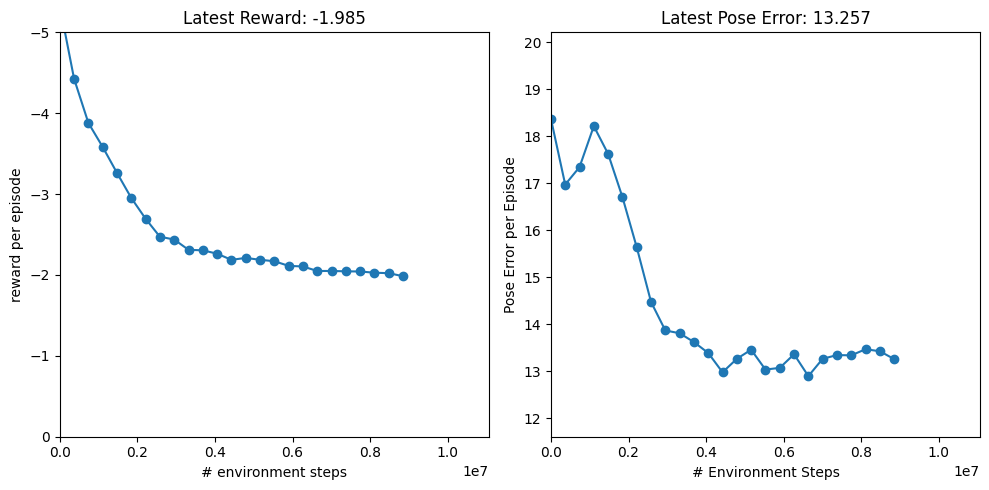

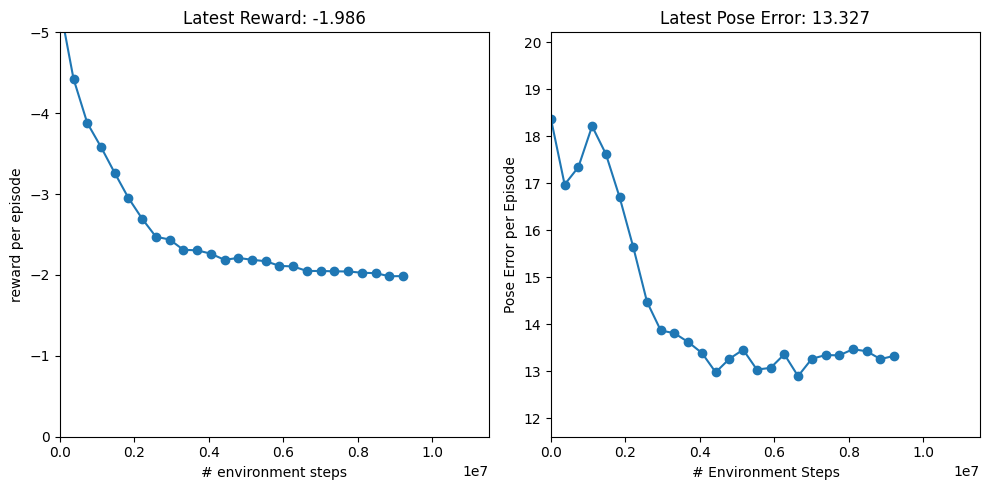

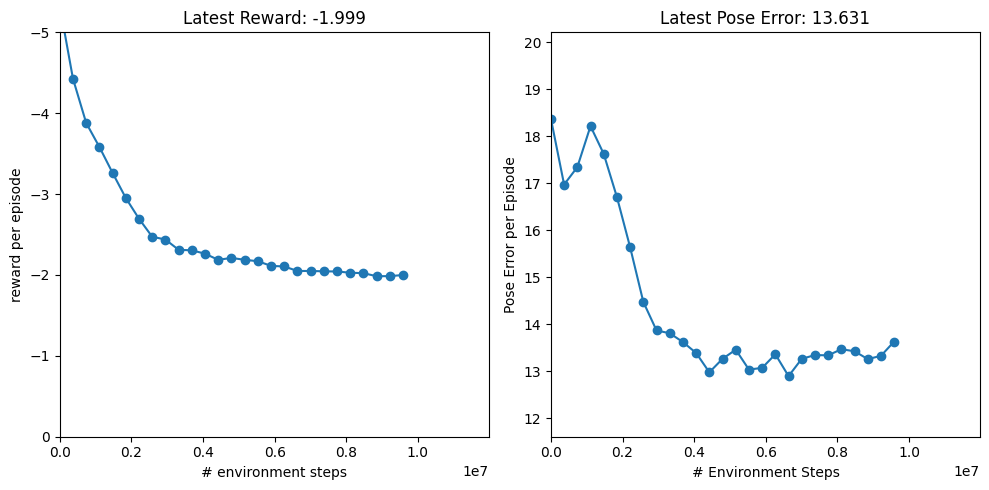

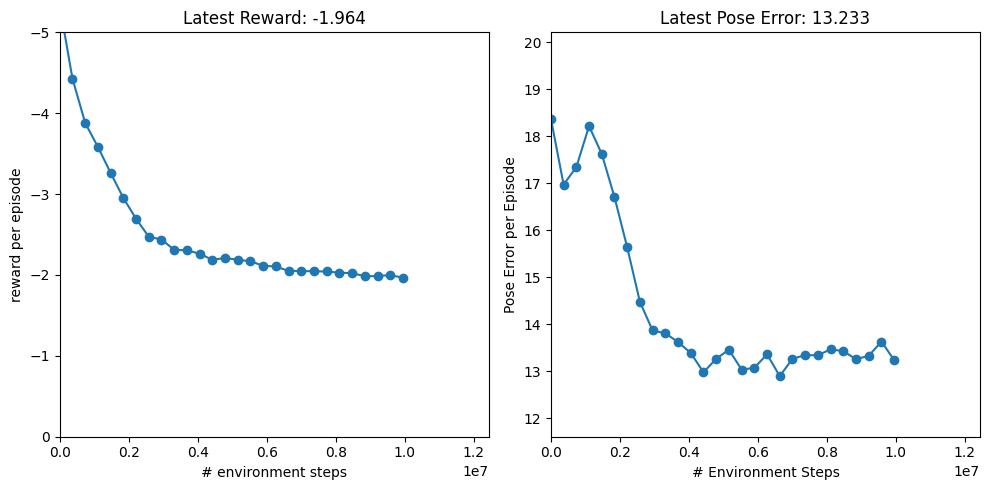

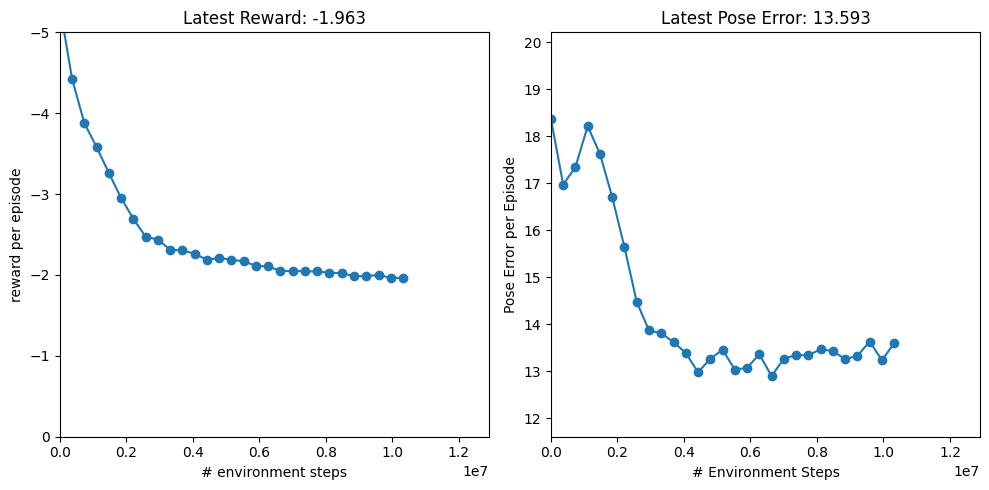

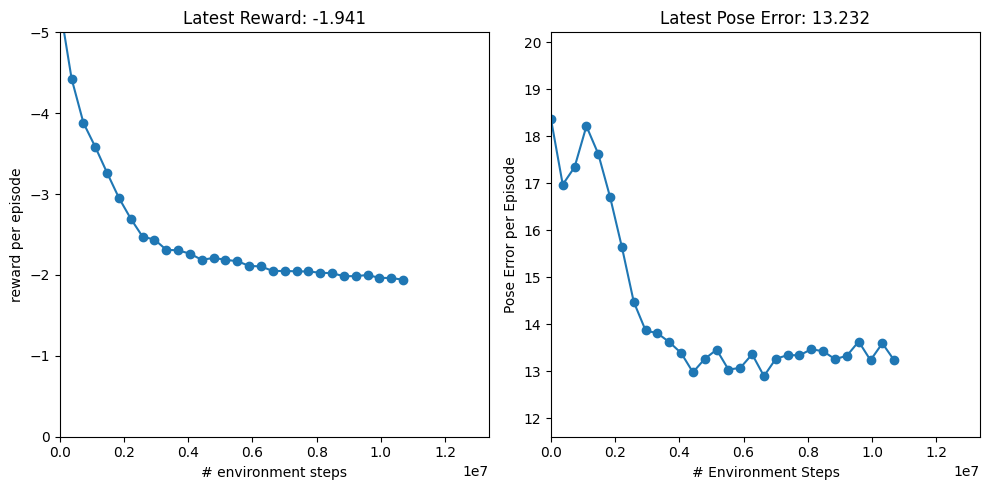

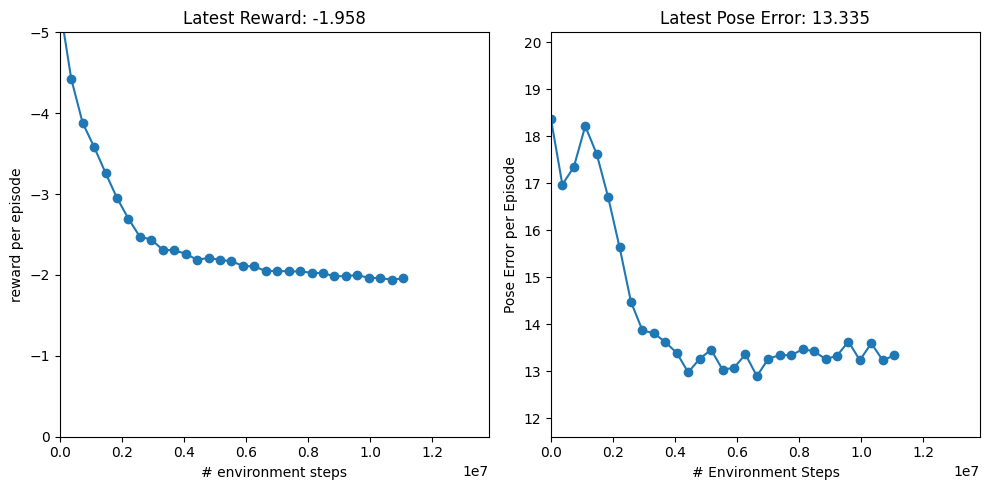

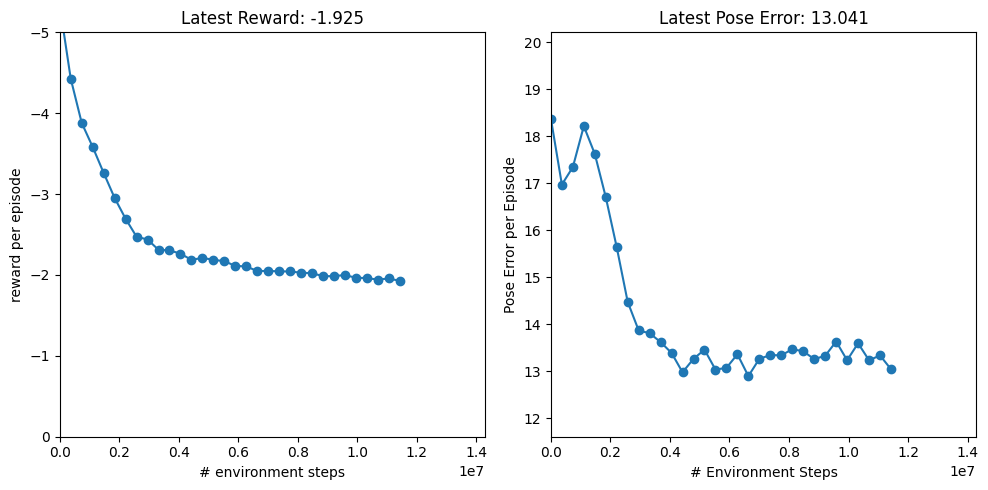

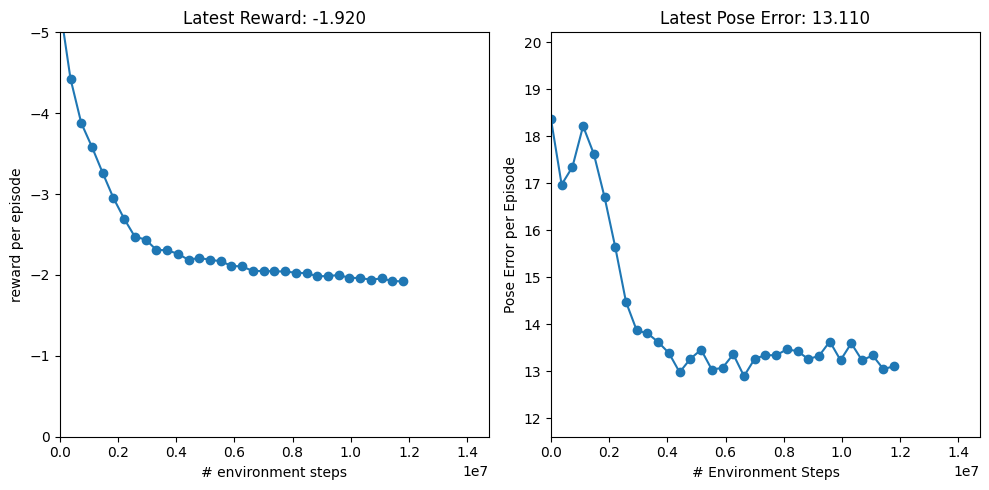

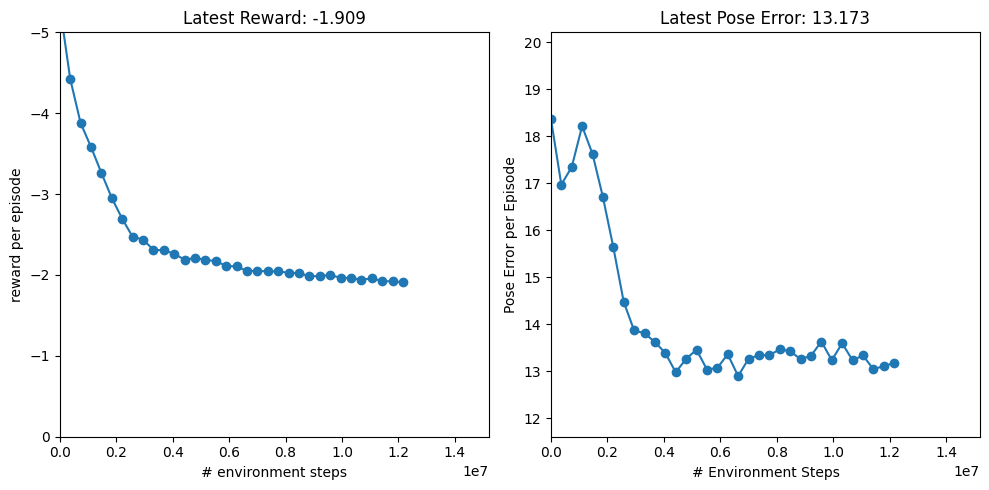

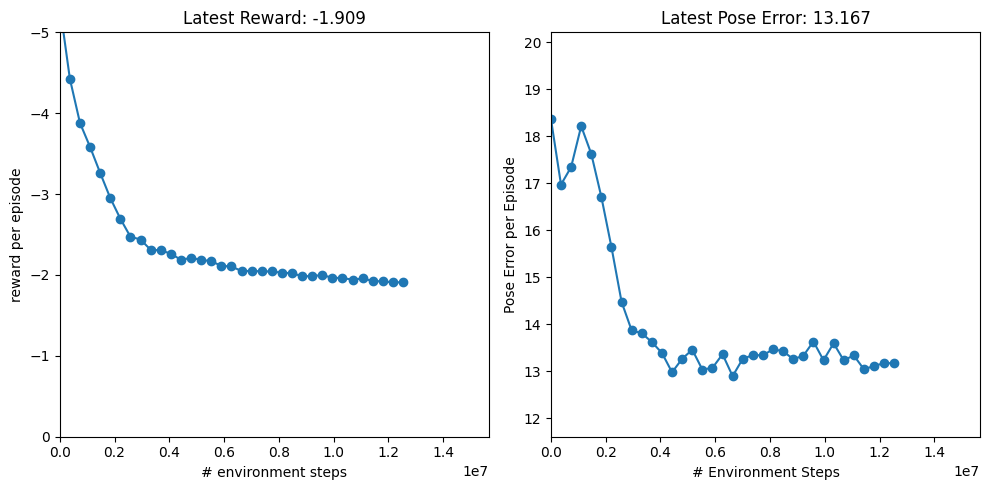

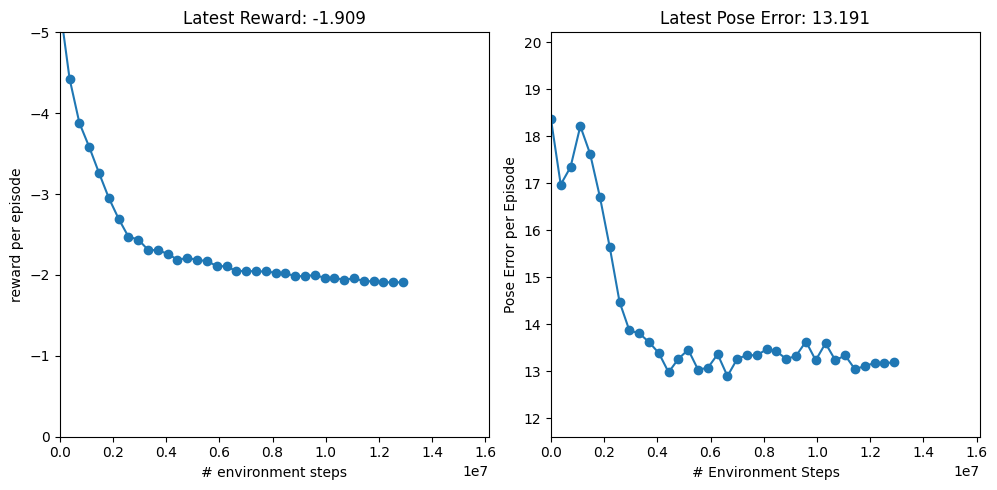

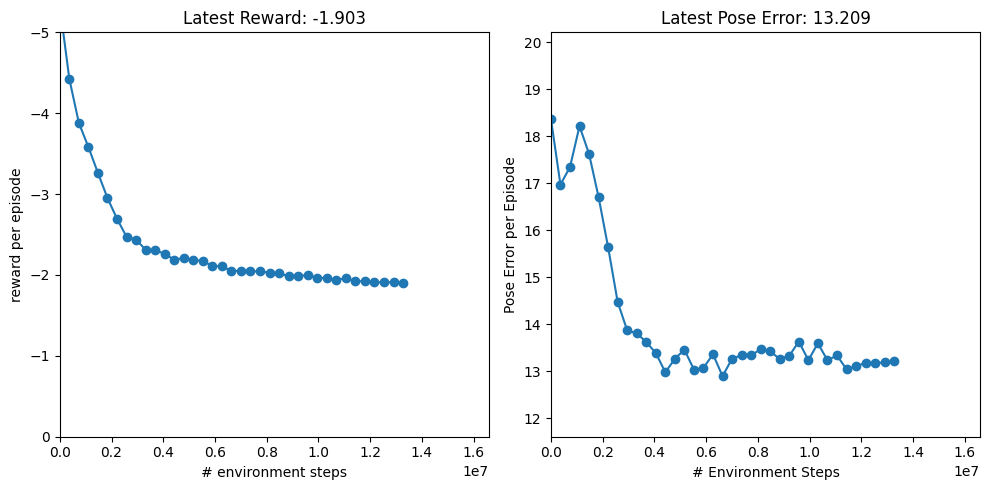

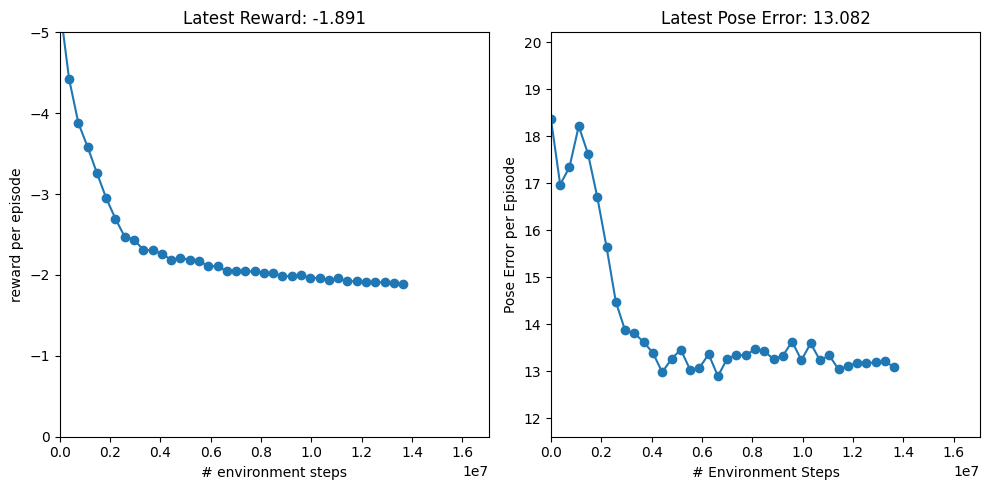

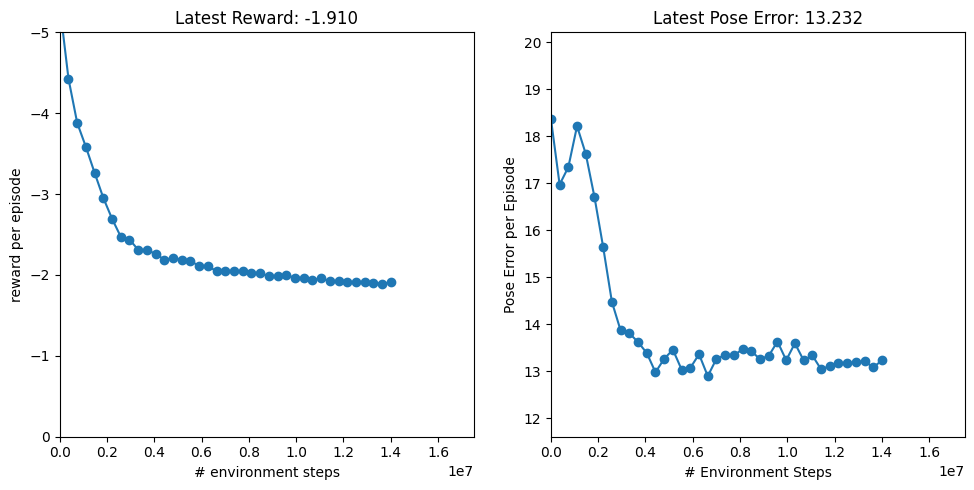

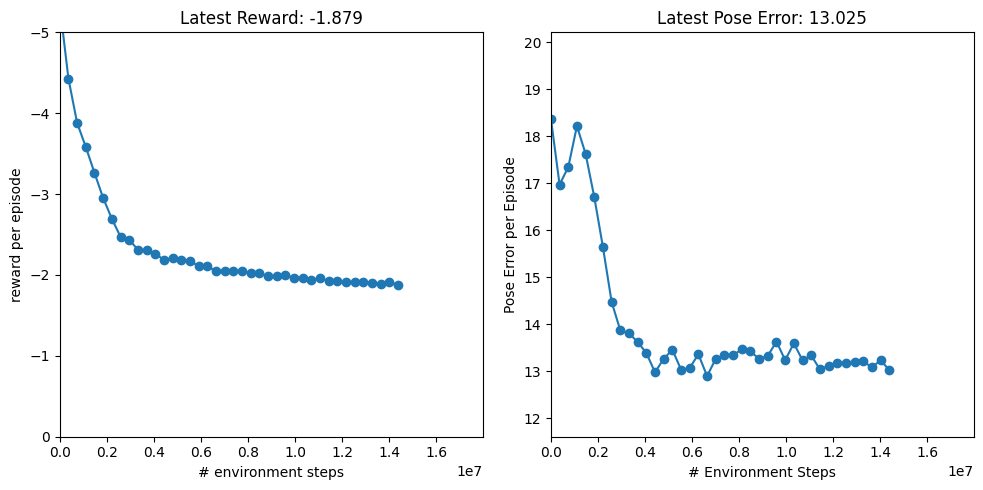

time to jit: 0:00:52.507846
time to train: 3:01:11.844672


In [13]:
# train_fn = functools.partial(
#     diff.train,
#     seed=args.seed,
#     episode_length=episode_len,
#     num_envs=args.num_envs,
#     num_eval_envs=args.num_eval_envs,
#     learning_rate=args.lr,
#     num_evals=args.max_it+1,
#     max_gradient_norm=args.max_grad_norm,
#     network_factory=functools.partial(apg_networks.make_apg_networks, hidden_layer_sizes=(512, 256)),
#     normalize_observations=args.normalize_observations,
#     use_linear_scheduler=args.use_lr_scheduler 
# )


# Adjusting parameters to ensure batch_size * num_minibatches is divisible by num_envs
train_fn = functools.partial(
    ppo.train,
    num_timesteps=10_000_000,  # Total timesteps for training
    #num_timesteps=100_000_000,  # Total timesteps for training
    num_evals=40,
    num_eval_envs=args.num_eval_envs,
    reward_scaling=1,
    episode_length=episode_len-1,  # Ensure episode_len is defined
    normalize_observations=args.normalize_observations,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=24,  # Adjusted number of minibatches
    num_updates_per_batch=4,
    discounting=0.97,  # Discount factor γ
    learning_rate=args.lr,
    entropy_cost=1e-2,
    num_envs=256,  # Changed number of parallel environments to match batch size
    batch_size=256,  # Adjusted batch size
    network_factory=make_networks_factory,
    seed=0  # Random seed for reproducibility
)




x_data = []
y_data = []
ydataerr = []
y_pose_error = []  # to store pose error
times = [datetime.now()]
max_y_rewards, min_y_rewards = 0, -5
def progress(num_steps, metrics):
  
  #print(num_steps)
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  y_pose_error.append(metrics['eval/episode_pose_error'])  # capture pose error
  
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1) 
  plt.xlim([0, num_steps* 1.25])
  plt.ylim([max_y_rewards, min_y_rewards])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'Latest Reward: {y_data[-1]:.3f}')
  plt.plot(x_data, y_data, '-o')
  
  plt.subplot(1, 2, 2)
  plt.xlim([0, num_steps* 1.25])
  plt.ylim([min(y_pose_error) * 0.9, max(y_pose_error) * 1.1])
  plt.xlabel('# Environment Steps')
  plt.ylabel('Pose Error per Episode')
  plt.title(f'Latest Pose Error: {y_pose_error[-1]:.3f}')
  plt.plot(x_data, y_pose_error, '-o')
  

  plt.tight_layout()
  plt.show()
  
make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=env_eval)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')



In [14]:
import os

# Create a directory if it does not exist
os.makedirs('model_checkpoints', exist_ok=True)

# Save in the subdirectory
model_path = 'model_checkpoints/model_punch3_policy'
model.save_params(model_path, params)

In [15]:
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [16]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

In [17]:
HTML(html.render(env_eval.sys.replace(dt=env_eval.dt), rollout))

In [18]:
import numpy as np
import jax.numpy as jnp

# Convert rollout to a numpy array if it's not already (assumes it's convertible directly)
rollout_array = np.array(rollout)
os.makedirs('rollout_check', exist_ok=True)
# Save the numpy array to a .npy file
np.save('rollout_check/rollout_please3.npy', rollout_array)